## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Merging Dataframes

1. 학생 정보 관련 파일:
   - studentInfo.csv: 학생의 인구 통계 정보, 등록 정보 등을 담고 있습니다.

2. 과정 정보 관련 파일:
   - courses.csv: 각 코스(모듈)에 대한 정보를 담고 있습니다.
   - assessments.csv: 코스 내의 평가 정보 (과제, 시험 등)를 담고 있습니다.

3. 학생 성적 관련 파일:
    - studentAssessment.csv: 학생들의 평가 점수를 담고 있습니다.
    - studentRegistration.csv: 학생의 코스 등록 정보를 담고 있습니다.
    
4. VLE 활동 관련 파일:
   - vle.csv: VLE 활동에 대한 설명 정보를 담고 있습니다.
   - studentVle.csv: 학생의 VLE(Virtual Learning Environment) 활동 데이터를 담고 있습니다.

In [84]:
assessments_df = pd.read_csv("./data/assessments.csv")
courses_df = pd.read_csv("./data/courses.csv")
studentAssessment_df = pd.read_csv("./data/studentAssessment.csv")

# vle_df = pd.read_csv("./data/vle.csv")
# studentVle_df = pd.read_csv("./data/studentVle.csv")

studentInfo_df = pd.read_csv("./data/studentInfo.csv")
studentRegistration_df = pd.read_csv("./data/studentRegistration.csv")

In [85]:
print('코스 내의 과제, 시험 정보',assessments_df.columns)
print('코스 정보',courses_df.columns)
print('학생 평가 점수',studentAssessment_df.columns)
print('학생 정보',studentInfo_df.columns)
print('학생의 등록 정보',studentRegistration_df.columns)
# print('vle 활동 정보',vle_df.columns)
# print('학생의 vle 활동 정보',studentVle_df.columns)

코스 내의 과제, 시험 정보 Index(['code_module', 'code_presentation', 'id_assessment', 'assessment_type',
       'date', 'weight'],
      dtype='object')
코스 정보 Index(['code_module', 'code_presentation', 'module_presentation_length'], dtype='object')
학생 평가 점수 Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score'], dtype='object')
학생 정보 Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
학생의 등록 정보 Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration'],
      dtype='object')


In [86]:
# 1. 학생 평가 점수와 과제 정보 병합
merged_df = studentAssessment_df.merge(assessments_df, on='id_assessment', how='left')
# 2. 학생 정보 추가
merged_df = merged_df.merge(studentInfo_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# 3. 학생 등록 정보 추가
merged_df = merged_df.merge(studentRegistration_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
# 4. 코스 정보 추가
merged_df = merged_df.merge(courses_df, on=['code_module', 'code_presentation'], how='left')

In [87]:
# 중복 행 제거
merged_df = merged_df.drop_duplicates()

In [88]:
# merged_df.to_csv('merged_data.csv')

In [89]:
# merged_vle_df = pd.merge(vle_df, studentVle_df, 
#                            on=['id_site', 'code_module', 'code_presentation'],
#                            how='outer')

In [90]:
# 중복 행 제거
# merged_vle_df = merged_vle_df.drop_duplicates()

In [91]:
# merged_vle_df.to_csv('./data/merged_vle_data.csv')

---
# 데이터 전처리

### 1. 결측치 처리

### `date`

- 대부분 `assessment_type = "Exam"`에 해당
- 시험은 일반적으로 강의 종료일에 시행됨
→ `module_presentation_length`를 활용해 **강의 마지막 날짜로 채움**

In [92]:
merged_data=merged_df
merged_data['is_late'] = (merged_data['date_submitted'] > merged_data['date']).astype(int)

In [93]:
# # # 2. 컬럼 이름 정리 (공백 제거)
# # merged_data.columns = merged_data.columns.str.strip()
# # courses.columns = courses.columns.str.strip()

# # 3. 'Exam'이고 date가 NaN인 행 필터링
# is_exam_nan = (merged_data['assessment_type'] == 'Exam') & (merged_data['date'].isna())

# # 4. 강의별 강의일수 정보 가져오기 (module_presentation_length)
# module_length_map = merged_data.set_index(['code_module', 'code_presentation'])['module_presentation_length']

# # 5. 결측 date 값 채우기
# def fill_exam_date(row):
#     if row['assessment_type'] == 'Exam' and pd.isna(row['date']):
#         return module_length_map.get((row['code_module'], row['code_presentation']), row['date'])
#     return row['date']

# merged_data['date'] = merged_data.apply(fill_exam_date, axis=1)


### 🔹 결측치 제거

### `score`

- 총 173건 결측
    - `Withdrawn`(이탈자): 72개
    - `Pass`, `Fail`, `Distinction`(수료자): 101개
- 과제를 제출했는데도 점수가 없는 경우로 추정… 수가 적으므로 **삭제 처리**

### `date_registration`

- 수강 등록일이 없는 7건 → **삭제**

In [94]:
# score가 NaN인 사람들 중에 이탈하지 않은 사람
score_nan_but_not_withdrawn = merged_data[merged_data['score'].isna() & (merged_data['final_result'] != 'Withdrawn')]

# score가 NaN인 사람들 중에 이탈한 사람
score_nan_and_withdrawn = merged_data[merged_data['score'].isna() & (merged_data['final_result'] == 'Withdrawn')]

# 결과 확인
# print(score_nan_but_not_withdrawn[['id_student', 'id_assessment', 'final_result']])
print(f"수료했는데도 score가 결측인 사람 수: {len(score_nan_but_not_withdrawn)}명")

# print(score_nan_and_withdrawn[['id_student', 'id_assessment', 'final_result']])
print(f"이탈했고 score가 결측인 사람 수: {len(score_nan_and_withdrawn)}명")


# Score 결측치 데이터(173개) + date_registration 결측치 데이터(7개) 데이터 제거

df_cleaned = merged_data.dropna(subset=['score','date_registration'])

df=df_cleaned


수료했는데도 score가 결측인 사람 수: 113명
이탈했고 score가 결측인 사람 수: 60명


### `imd_band`

- 총 7697건 결측
- 전체 28,785명 중 약 **971명**의 `imd_band`(지역 기반 사회경제 수준 지표)가 없음

- imd_band에 데이터를 넣는코드

In [95]:
# 'imd_band' 컬럼의 NaN 값을 'Unknown'으로 채우기
# unknown 대신 다른 문자열로 채울 수 있음
# 숫자로도 넣을 수 있음.
df.loc[:, 'imd_band'] = df['imd_band'].fillna('Unknown')

- 'imd_band' 컬럼에서 결측치가 있는 행을 삭제

In [96]:
df = df.dropna(subset=['imd_band','date'])

In [97]:
df.isnull().sum()

id_assessment                      0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
code_module                        0
code_presentation                  0
assessment_type                    0
date                               0
weight                             0
gender                             0
region                             0
highest_education                  0
imd_band                           0
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                   16552
date_registration                  0
date_unregistration           157891
module_presentation_length         0
is_late                            0
dtype: int64

In [98]:
print(df['imd_band'].isna().sum())  # NaN 개수 확인
print(df['imd_band'].unique())  # imd_band 컬럼의 고유값 확인

0
['90-100%' '20-30%' '50-60%' '80-90%' '30-40%' '70-80%' 'Unknown' '60-70%'
 '40-50%' '10-20%' '0-10%']


In [99]:
display(df['imd_band'].unique())

imd_band_to_income = {
    '90-100%': 9,  
    '80-90%': 8,  
    '70-80%': 7, 
    '60-70%': 6, 
    '50-60%': 5, 
    '40-50%': 4, 
    '30-40%': 3,  
    '20-30%': 2,    
    '10-20': 1, 
    '0-10%': 0,    
    'Unknown': 0     
}

df['imd_band'] = df['imd_band'].map(imd_band_to_income)

array(['90-100%', '20-30%', '50-60%', '80-90%', '30-40%', '70-80%',
       'Unknown', '60-70%', '40-50%', '10-20%', '0-10%'], dtype=object)

/tmp/ipykernel_75176/307312118.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['imd_band'] = df['imd_band'].map(imd_band_to_income)


### `date_unregistration`

- 결측치 160,857건
- 해당 컬럼은 **"언제 수강을 중도 이탈했는가"**를 의미
→ **결측 = 중도 이탈하지 않은 수료자**
→ 즉, 의미 있는 결측이므로 **삭제하지 않음** → 인코딩 과정에서 결측치를 처리 한다!!!

---

- date_unregistration 이상치 제거
- Fail값이 나올 수 없기 때문에 이상치 처리해야함!!!!!!!!!!!!!!!!!!!!
- 조건 -> final_result 값 안에 Fail 일 때 date_unregistration이 0보다 크거나 같을 때

### `final_result 이상치 처리 코드`

In [100]:
df[(df['final_result'] == 'Fail') & (df['date_unregistration'] >= 0)]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,...,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,is_late
15046,14996,554243,18,0,61.0,BBB,2013J,TMA,19.0,5.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,0
16810,14997,554243,47,0,81.0,BBB,2013J,TMA,47.0,18.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,0
22931,15003,554243,56,0,100.0,BBB,2013J,CMA,54.0,1.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,1
24489,15004,554243,102,0,80.0,BBB,2013J,CMA,96.0,1.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,1
26445,15005,554243,133,0,80.0,BBB,2013J,CMA,131.0,1.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,1
26904,15006,554243,168,0,100.0,BBB,2013J,CMA,166.0,1.0,...,6.0,0-35,0,60,N,Fail,-35.0,166.0,268,1
76597,25348,403052,26,0,32.0,DDD,2013J,TMA,25.0,10.0,...,2.0,0-35,0,150,N,Fail,-22.0,0.0,261,1
77242,25349,403052,53,0,39.0,DDD,2013J,TMA,53.0,12.5,...,2.0,0-35,0,150,N,Fail,-22.0,0.0,261,0
78690,25350,403052,89,0,68.0,DDD,2013J,TMA,88.0,17.5,...,2.0,0-35,0,150,N,Fail,-22.0,0.0,261,1
80366,25351,403052,128,0,25.0,DDD,2013J,TMA,123.0,20.0,...,2.0,0-35,0,150,N,Fail,-22.0,0.0,261,1


In [101]:
df = df.drop(df[(df['final_result'] == 'Fail') & (df['date_unregistration'] >= 0)].index)

In [102]:
merged_data=df

### 2. 이상치 처리 및 시각화
   - 수치형 변수의 이상치 확인 및 처리(예: score, studied_credits의 극단값 혹은 0 값 등)

### 3. 데이터 타입 변환
   - 날짜 관련 변수를 datetime 형식으로 변환
   - 범주형 변수를 category 타입으로 변환

### 4. 특성 엔지니어링

#### 학생의 성적 관련 특성
  - 각 학생의 평균 점수, 최고 점수, 최저 점수, 점수의 표준편차
    - 각 학생당 코스별 성적 편차 필요할까?
  - 점수 추세 (상승 또는 하락)
  - 과제 난이도에 따른 가중 점수 -> 난이도 기준을 뭘로 잡아야하나?
 
##### my_average_score, my_max_score, my_min_score, my_score_std, my_score_trend, assesment_weight, weighted_score

- my_avg_score : 개인 학업 성취도 수준 파악
- my_max/min_score/my_score_std : 특정 과목 강점/약점 식별 및 극단적 편차 분석
- my_score_trend	: 학습 효과성 평가 (지속적 상승=효율적 학습법, 하락=개입 필요)
- weighted_score :	난이도 대비 성취도 → "B과제는 고난이도지만 고가중점수 → Distinct 학생" 

In [103]:
# 학생의 평균, 최고, 최저 점수 및 표준편차 계산
student_scores = merged_data.groupby('id_student')['score'].agg(['mean', 'max', 'min', 'std']).reset_index()
student_scores.columns = ['id_student', 'my_average_score', 'my_max_score', 'my_min_score', 'my_score_std']

# # 학생의 코스별 성적 표준편차 계산
# score_std_by_module = merged_data.groupby(['id_student', 'code_module'])['score'].std().reset_index()
# score_std_by_module = score_std_by_module.pivot(index='id_student', columns='code_module', values='score').reset_index()
# score_std_by_module.columns = ['id_student'] + [f'score_std_{col}' for col in score_std_by_module.columns if col != 'id_student']

# 점수 추세 분석
merged_data_sorted = merged_data.sort_values(by=['id_student', 'date_submitted'])
merged_data_sorted['score_diff'] = merged_data_sorted.groupby('id_student')['score'].diff()

def determine_trend(diff):
    if diff > 0:
        return 1
    else:
        return 0
    
merged_data_sorted['score_trend'] = merged_data_sorted['score_diff'].apply(determine_trend)
student_trends = merged_data_sorted.groupby('id_student')['score_trend'].apply(lambda x: x.value_counts().idxmax()).reset_index()
student_trends.columns = ['id_student', 'my_score_trend']

# 모든 특성을 하나의 데이터프레임으로 병합
student_features = pd.merge(student_scores, student_trends, on='id_student')

# 원본 데이터와 새로운 특성을 병합
merged_data = pd.merge(merged_data, student_features, on='id_student')

# 과제 난이도 가중치를 적용한 점수 (평균 기반)

# weight 계산 (평균 점수가 낮을수록 가중치가 높아짐)
avg = merged_data.groupby('id_assessment')['score'].mean()
max_avg = avg.max()
weight = (max_avg - avg) / (max_avg - avg).sum()

# weight를 데이터프레임으로 변환
weight_df = weight.reset_index()
weight_df.columns = ['id_assessment', 'assessment_weight']
merged_data = pd.merge(merged_data, weight_df, on='id_assessment', how='left')

# 가중 점수 계산
merged_data['weighted_score'] = merged_data['score'] * merged_data['assessment_weight']

#### 코스 관련 특성
  - 코스별 평균 점수, 최고 점수, 최저 점수, 점수의 표준편차 -> 최저 점수 다 0임, 최고점이 필요한가?, 중간값이 필요한가?
  - 코스별 과제 개수

##### 'course_avg_score', 'course_std_score', 'assignment_count'

- course_avg_score, course_std_score :	평가 방식 적정성 → 편차↑=과도한 변별력 / 강좌 난이도 레벨링
- assignment_count :	과제량-성적 상관관계 분석 → 최적 과제량 도출

In [104]:
# 과목별 통계 계산
subject_stats = merged_data.groupby(['code_presentation', 'code_module']).agg({
    'score': ['mean', 'max', 'std']
})
subject_stats.columns = ['course_avg_score', 'course_max_score', 'course_std_score']

# 과목 통계 데이터 병합
merged_data = merged_data.merge(
    subject_stats.reset_index(),
    on=['code_presentation', 'code_module'],
    how='left'
)
merged_data['assignment_count'] = merged_data.groupby(['code_presentation', 'code_module'])['id_assessment'].transform('nunique')

# # 과목별 난이도 가중치를 적용한 점수 (표준편차 기반)
# difficulty = subject_stats['course_std_score']
# weights = (difficulty / difficulty.sum()) * 10
# merged_data = merged_data.merge(
#     weights.rename('course_weight'), 
#     left_on='code_module', 
#     right_index=True
# )
# merged_data['weighted_score'] = merged_data['score'] * merged_data['course_weight']

In [105]:
merged_data[merged_data['code_module']=='AAA']

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,...,my_max_score,my_min_score,my_score_std,my_score_trend,assessment_weight,weighted_score,course_avg_score,course_max_score,course_std_score,assignment_count
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,...,85.0,78.0,3.082207,0,0.007034,0.548627,69.431637,98.0,12.639410,5
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,...,70.0,60.0,4.335897,0,0.007034,0.492358,69.431637,98.0,12.639410,5
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,...,88.0,71.0,6.892024,0,0.007034,0.506425,69.431637,98.0,12.639410,5
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,...,75.0,30.0,20.513410,0,0.007034,0.485324,69.431637,98.0,12.639410,5
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,...,79.0,50.0,10.977249,0,0.007034,0.555661,69.431637,98.0,12.639410,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,1762,2654628,216,0,74.0,AAA,2014J,TMA,215.0,30.0,...,74.0,69.0,2.509980,0,0.007358,0.544481,68.598680,95.0,13.291518,5
3142,1762,2677624,215,0,79.0,AAA,2014J,TMA,215.0,30.0,...,79.0,58.0,9.181503,0,0.007358,0.581270,68.598680,95.0,13.291518,5
3143,1762,2680312,220,0,85.0,AAA,2014J,TMA,215.0,30.0,...,86.0,73.0,6.220932,0,0.007358,0.625417,68.598680,95.0,13.291518,5
3144,1762,2688166,214,0,46.0,AAA,2014J,TMA,215.0,30.0,...,69.0,46.0,11.030261,0,0.007358,0.338461,68.598680,95.0,13.291518,5


#### 행동 패턴 특성
- 전체 학생 기준
  - 코스별 과제 제출률 => 제출률 100프로
  - 코스별 지각 제출 비율
  - 과제별 제출 시간의 평균, 중앙값, 표준편차

- 한명 학생 기준
  - 과제 제출률 => 제출률 100프로
  - 지각 제출 비율
  - 이탈 학생의 이탈 단계 할당

##### 'course_late_rate', 'my_late_rate', 'days_early_submission_avg', 'days_early_submissione_max', 'days_early_submission_min','days_early_submission_std','days_early_submission', 'is_late', 'unregistration_stage'

- my_late_rate	: 습관적 지각 여부 → 학습태도 평가 지표
- days_early_submission_*	: 과제의 난의도 판별 → 평균 7일 이상 = 쉬운 과제인가, 평균 0일 이하 = 어려운 과제인가, 표준편차가 크다 = 학생의 역량
- course_late_rate : 코스의 난의도 판별 -> 필요없을까?
- unregistration_stage : 첫 번째 과제 이후 이탈-> 수업의 어려움보다는 외부적인 이유일 가능성이 높음 / 중간쯤 과제 제출 후 이탈->학업에서의 고충이나 과제의 난이도 등이 영향이 있을 수 있음

In [106]:
# 모든 학생 기준
# 1. 코스별 평균 제출률 계산
# 1-1. 학생별 코스 내 제출률 계산
# student_course_submission = merged_data.groupby(['code_module', 'id_student']).agg(
#     student_submissions=('id_assessment', 'count'),
#     course_assessments=('id_assessment', 'nunique')
# ).astype({'student_submissions': int, 'course_assessments': int}).reset_index()

# # 1-2. 학생별 제출률 계산
# student_course_submission['student_submission_rate'] = (
#     student_course_submission['student_submissions']
#     / student_course_submission['course_assessments']
# )
# course_stats = student_course_submission.groupby('code_module')['student_submission_rate'].mean().reset_index()
# course_stats.columns = ['code_module', 'course_avg_submission_rate']
# student_course_submission[student_course_submission['student_submission_rate'] != 1]

# 2. 코스별 지각 제출 비율
# 3. 과제별 제출시간 평균, 중간, 표준편차

# 개인기준
# # 1. 학생별 과제 제출률
# student_stats = merged_data.groupby('id_student').agg(
#     student_submissions=('id_assessment', 'count'),
#     total_assignments=('id_assessment', 'nunique')
# ).reset_index()
# student_stats['student_submission_rate'] = student_stats['student_submissions'] / student_stats['total_assignments']
# student_stats[student_stats['student_submission_rate'] != 1]

# 2. 학생별 지각 제출 비율

In [107]:
# 코스별 지각 제출 비율
# merged_data['is_late'] = (merged_data['date_submitted'] > merged_data['date']).astype(int)
merged_data['course_late_rate'] = merged_data.groupby(['code_presentation', 'code_module'])['is_late'].transform('mean')

# 과제별 데드라인 전 제출 시간 평균, 중간, 표준편차
merged_data['days_early_submission'] = merged_data['date'] - merged_data['date_submitted']  # 컬럼명 변경 권장
assessment_stats = merged_data.groupby('id_assessment')['days_early_submission'].agg([
    ('days_early_submission_avg', 'mean'),
    ('days_early_submission_max', 'max'),
    ('days_early_submission_min', 'min'),
    ('days_early_submission_std', 'std')
]).reset_index()
merged_data = merged_data.merge(assessment_stats, on='id_assessment')

# 학생별 지각 제출 비율
merged_data['my_late_rate'] = merged_data.groupby('id_student')['is_late'].transform('mean')

In [108]:
dropped_out_students = merged_data[merged_data['date_unregistration'].notnull()]

# 이탈한 학생이 제출한 과제 수 계산 (학생, 과목별로 그룹화)
submitted_assignments = dropped_out_students.groupby(['id_student', 'code_presentation', 'code_module'])['id_assessment'].count().reset_index()
submitted_assignments.rename(columns={'id_assessment': 'submitted_count'}, inplace=True)
merged_data = merged_data.merge(submitted_assignments, on=['id_student', 'code_presentation', 'code_module'], how='left')

# 이탈 학생의 과제 제출률 계산 (이탈 학생의 과목당 제출 과제 수 / 과목당 전체 과제 수)
merged_data['submitted_proportion'] = merged_data['submitted_count'] / merged_data['assignment_count']
merged_data['submitted_proportion'] = merged_data['submitted_proportion'].fillna(0)

# 이탈 학생의 이탈 단계 할당
def assign_stage_based_on_proportion(row):
    if pd.isna(row['date_unregistration']):
        return 0
    elif row['submitted_proportion'] < 0.33:  # Less than 33% of total assignments
        return 1
    elif row['submitted_proportion'] < 0.66:  # Between 33% and 66%
        return 2
    else:                                     # More than 66%
        return 3

merged_data['unregistration_stage'] = merged_data.apply(assign_stage_based_on_proportion, axis=1)

In [109]:
merged_data = merged_data.drop(['submitted_count','assignment_count','date_unregistration'], axis=1)
merged_data.isnull().sum()

id_assessment                     0
id_student                        0
date_submitted                    0
is_banked                         0
score                             0
code_module                       0
code_presentation                 0
assessment_type                   0
date                              0
weight                            0
gender                            0
region                            0
highest_education                 0
imd_band                      16552
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                  16552
date_registration                 0
module_presentation_length        0
is_late                           0
my_average_score                  0
my_max_score                      0
my_min_score                      0
my_score_std                   1953
my_score_trend                    0
assessment_weight           

In [110]:
merged_data.loc[merged_data['unregistration_stage'].notnull(), 
                ['id_student','code_presentation', 'code_module','unregistration_stage']]


,id_student,code_presentation,code_module,unregistration_stage
0,11391,2013J,AAA,0
1,28400,2013J,AAA,0
2,31604,2013J,AAA,0
3,32885,2013J,AAA,0
4,38053,2013J,AAA,0
...,...,...,...,...
170852,527538,2014J,GGG,0
170853,534672,2014J,GGG,0
170854,546286,2014J,GGG,0
170855,546724,2014J,GGG,0


#### 아래부터는 EDA 아이디어가 정해진 후 진행

### 5. 불필요한 특성 제거
   - 분석에 불필요하거나 중복되는 정보를 가진 열 제거

### 6. 범주형 변수 인코딩
   - 필요에 따라 원-핫 인코딩 또는 라벨 인코딩 적용

In [111]:
df=merged_data

In [112]:

df.loc[:, 'final_result'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)

# df.loc[:, 'date_unregistration'] = df['date_unregistration'].apply(lambda x: 1 if pd.notna(x) else 0)

# -> 조건을 주지 않고 원 핫 인코딩을 실행함
encode_cols = ['code_module', 'code_presentation', 'assessment_type']
df_encoded = pd.get_dummies(df[encode_cols], drop_first=False)

# 'age_band' 값을 매핑하여 숫자로 변환
df['age_band'] = df['age_band'].astype(str)
age_band_map = {'0-35': 0, '35-55': 1, '55<=': 2}
df['age_band'] = df['age_band'].map(age_band_map)

# 원핫인코딩 제외한 나머지 컬럼 가져오기
df_other = df.drop(columns=encode_cols)

# 변환된 데이터프레임 합치기
df = pd.concat([df_other, df_encoded], axis=1)

# 결과 확인
df['final_result'].value_counts()
df['final_result']=df['final_result'].astype(int)


In [113]:
df = df[merged_data['is_banked']==0]
df = df.drop('is_banked', axis=1)


education_to_income = {
    'Post Graduate Qualification': 6926,  
    'HE Qualification': 4699,      
    'A Level or Equivalent': 3630,     
    'Lower Than A Level': 3576,        
    'No Formal quals': 3000     
}

df['highest_education'] = df['highest_education'].map(education_to_income)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168953 entries, 0 to 170856
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_assessment               168953 non-null  int64  
 1   id_student                  168953 non-null  int64  
 2   date_submitted              168953 non-null  int64  
 3   score                       168953 non-null  float64
 4   date                        168953 non-null  float64
 5   weight                      168953 non-null  float64
 6   gender                      168953 non-null  object 
 7   region                      168953 non-null  object 
 8   highest_education           168953 non-null  int64  
 9   imd_band                    152608 non-null  float64
 10  age_band                    152608 non-null  float64
 11  num_of_prev_attempts        168953 non-null  int64  
 12  studied_credits             168953 non-null  object 
 13  disability         

### 7. 스케일링(-> 모델링 시점에 할 지 안할지 정해도 될듯)
   - 수치형 변수에 대해 표준화 또는 정규화 적용

---
# **Exploratory Data Analysis**

## **특성간의 상관관계 확인**
- 특성간의 상관관계 확인 후 상관계수가 높은 변수끼리 그룹화하여 그룹별 성과와의 상관관계 분석

In [114]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 168953 entries, 0 to 170856
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_assessment               168953 non-null  int64  
 1   id_student                  168953 non-null  int64  
 2   date_submitted              168953 non-null  int64  
 3   score                       168953 non-null  float64
 4   date                        168953 non-null  float64
 5   weight                      168953 non-null  float64
 6   gender                      168953 non-null  object 
 7   region                      168953 non-null  object 
 8   highest_education           168953 non-null  int64  
 9   imd_band                    152608 non-null  float64
 10  age_band                    152608 non-null  float64
 11  num_of_prev_attempts        168953 non-null  int64  
 12  studied_credits             168953 non-null  object 
 13  disability         

Index(['id_assessment', 'id_student', 'date_submitted', 'score', 'date',
       'weight', 'gender', 'region', 'highest_education', 'imd_band',
       'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result', 'date_registration', 'module_presentation_length',
       'is_late', 'my_average_score', 'my_max_score', 'my_min_score',
       'my_score_std', 'my_score_trend', 'assessment_weight', 'weighted_score',
       'course_avg_score', 'course_max_score', 'course_std_score',
       'course_late_rate', 'days_early_submission',
       'days_early_submission_avg', 'days_early_submission_max',
       'days_early_submission_min', 'days_early_submission_std',
       'my_late_rate', 'submitted_proportion', 'unregistration_stage',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_201

In [115]:
# df.to_csv('data/merged_data_finall.csv')

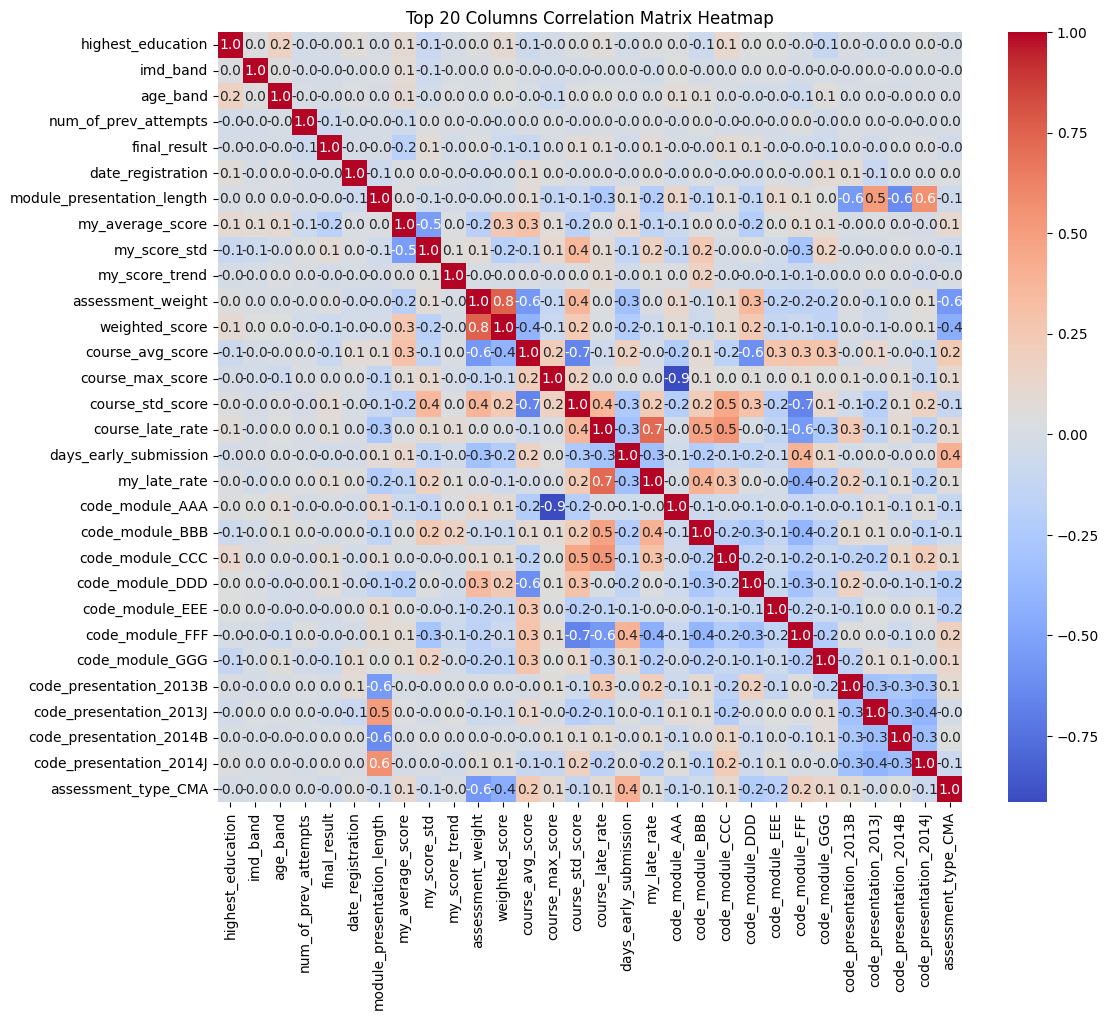

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 행렬 계산
# df.columns  

matrix = df.drop(columns=['my_min_score','my_max_score','id_assessment','id_student','score',
                          'is_late','days_early_submission_max','days_early_submission_min',
                          'days_early_submission_std','days_early_submission_avg', 'date','weight',
                          'date_submitted', 'region', 'unregistration_stage', 'submitted_proportion'])

corr_matrix = matrix.corr(numeric_only=True)
corr_matrix

# 상위 20개 컬럼만 선택
top_20_columns = corr_matrix.columns[:30]
top_20_corr_matrix = corr_matrix.loc[top_20_columns, top_20_columns]

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(top_20_corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.title('Top 20 Columns Correlation Matrix Heatmap')
plt.show()

In [117]:
# from itertools import combinations
# numeric_df = matrix.select_dtypes(include=['int64', 'float64', 'bool'])

# column_pairs = list(combinations(numeric_df.columns, 2))

# for x_col, y_col in column_pairs:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(data=numeric_df, x=x_col, y=y_col, alpha=0.5)
#     plt.title(f"Scatter Plot: {x_col} vs {y_col}")
#     plt.tight_layout()
#     plt.show()

In [134]:
numeric_df = matrix.select_dtypes(include=['int64', 'float64', 'bool'])
# for col in numeric_df.columns:
#     if col != 'final_result':
#         plt.figure(figsize=(6, 4))
#         sns.scatterplot(data=numeric_df, x='final_result', y=col, alpha=0.5)
#         plt.title(f"Scatter Plot: final_result vs {col}")
#         plt.tight_layout()
#         plt.show()

### 여기부터는 위의 상관관계 확인후 분석 들어가야함

## (예시)**온라인 학습 활동 분석**
- sum_click(총 클릭 수)와 final_result(최종 성적) 간 상관관계 분석
- 학습 콘텐츠 유형(activity_type)별 평균 클릭 수(sum_click) 비교
- week_from, week_to를 활용한 주차별 학습 패턴 분석 (lineplot)

## (예시)**학생의 연령, 교육 수준, 장애 여부 등이 학습 성과와 관련 있는지 분석**
- age_band, highest_education, disability 등과 final_result 간 분포 비교 (countplot)
- num_of_prev_attempts(재수강 횟수)와 final_result 간 상관관계 분석
- date_unregistration 값이 있는 경우, 조기 이탈 학생과 학습 활동 비교

---

### randomforest

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)


# 학습
X_train = numeric_df.drop(['final_result'],axis=1)
y_train = numeric_df['final_result']

rf_clf.fit(X_train, y_train)

y_pred_train = rf_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

# y_pred_test = rf_clf.predict(X_test)
# acc_score_test = accuracy_score(y_test, y_pred_test)
# print('테스트 평가 점수:', acc_score_test)

학습 점수: 0.9350529437180755


        my_score_std  my_average_score  my_late_rate  weighted_score  \
0           3.082207         82.000000      0.000000        0.548627   
1           4.335897         66.400000      0.400000        0.492358   
2           6.892024         76.000000      0.000000        0.506425   
3          20.513410         54.400000      1.000000        0.485324   
4          10.977249         68.000000      0.200000        0.555661   
...              ...               ...           ...             ...   
170852     17.098570         73.888889      0.000000        0.152195   
170853     15.279928         79.857143      0.285714        0.253658   
170854     11.597414         87.250000      0.125000        0.202927   
170855     23.925811         81.222222      0.333333        0.253658   
170856     14.324610         68.222222      0.000000        0.202927   

        age_band  num_of_prev_attempts  course_std_score  imd_band  \
0            2.0                     0         12.639410       9.

<Axes: xlabel='None', ylabel='None'>

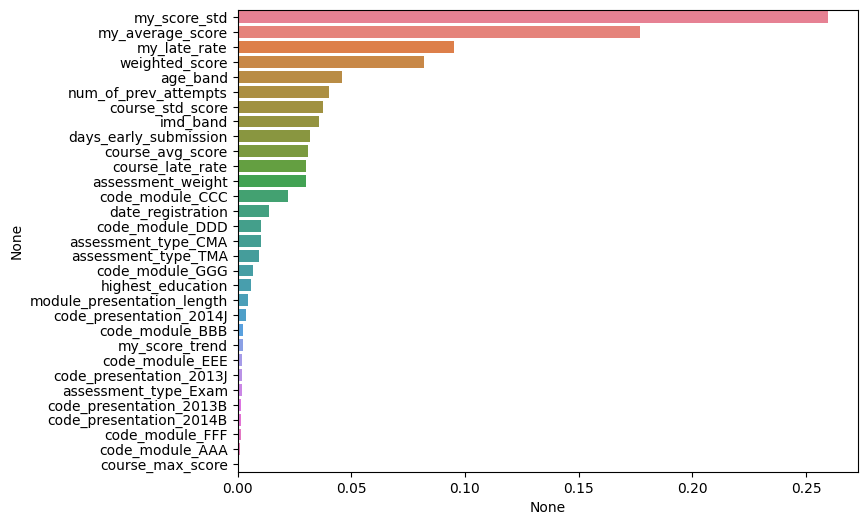

In [ ]:
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)


X_train2 = X_train[feat_imptc_ser[:20].keys()]



# 특성 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue=feat_imptc_ser.index
)